In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr



PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Generating Noise

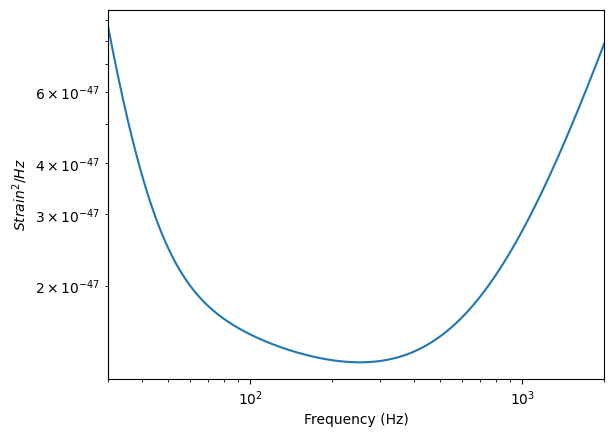

In [2]:
def gen_noise(psd_need):
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    if (psd_need == True) :
        pp.plot(psd.sample_frequencies,psd.data)
        pp.loglog()
        pp.xlim(30,2000)
        pp.ylabel('$Strain^2 / Hz$')
        pp.xlabel('Frequency (Hz)')
        pp.show()


    # Generate 512 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(512/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)
    
    
    #plotting noise 
#     pp.plot(ts.sample_times, ts)
#     pp.ylabel('Strain')
#     pp.xlabel('Time (s)')
#     pp.show()
    

    return ts

noise = gen_noise(True)

# Generating Strain

fp=0.5494252193754385, fc=-0.5320202660769405


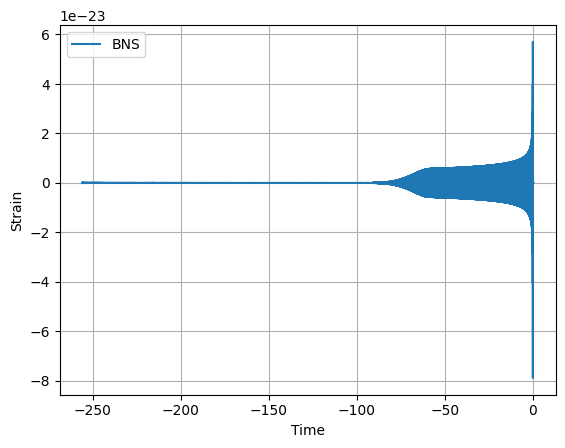

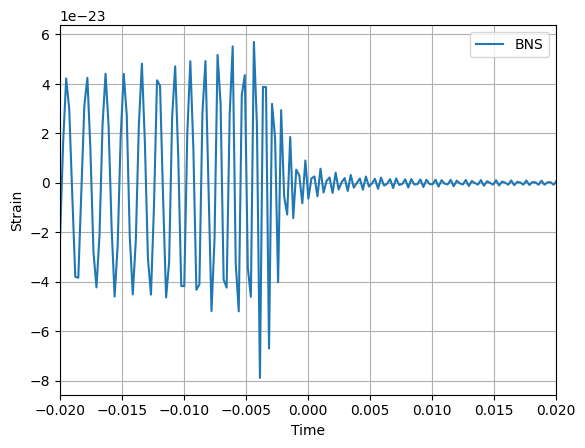

fp=0.5494252193754385, fc=-0.5320202660769405


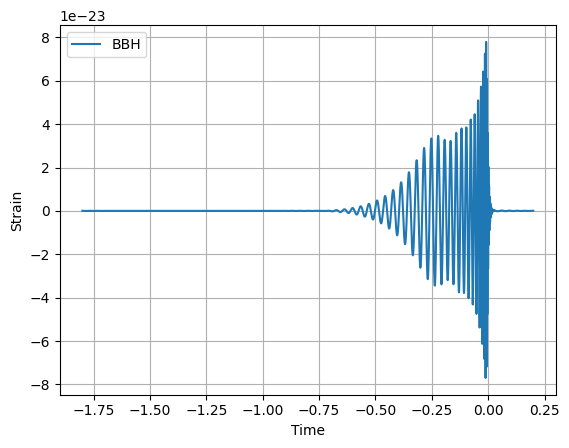

In [3]:
def gen_waveform(model,m1,m2,s1z,s2z,distance,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform


   
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0




    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    print("fp={}, fc={}".format(fp, fc))

    # These factors allow us to project a signal into what the detector would observe
    # IMRPhenomPv2
    # Generate the waveform for the BNS merger
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ## Apply the factors to get the detector frame strain
    ht_1 = fp * hp_1 + fc * hc_1
    
    
    pp.plot(ht_1.sample_times, ht_1, label=l)
    pp.legend()
    pp.ylabel('Strain')
    pp.xlabel('Time')
    pp.grid()
    pp.show()
    
    
    
    return ht_1

# generating BNS signal

h1_bns = gen_waveform('TaylorF2',1.4,1.3,0.5,0.5,200,0.0,"BNS")

pp.plot(h1_bns.sample_times, h1_bns, label='BNS')
pp.legend()
pp.xlim(-0.02,0.02)
pp.ylabel('Strain')
pp.xlabel('Time')
pp.grid()
pp.show()




h1_bbh = gen_waveform('IMRPhenomPv2',30,40,0.8,0.8,8000,0.0,"BBH")



# Combining the Signals

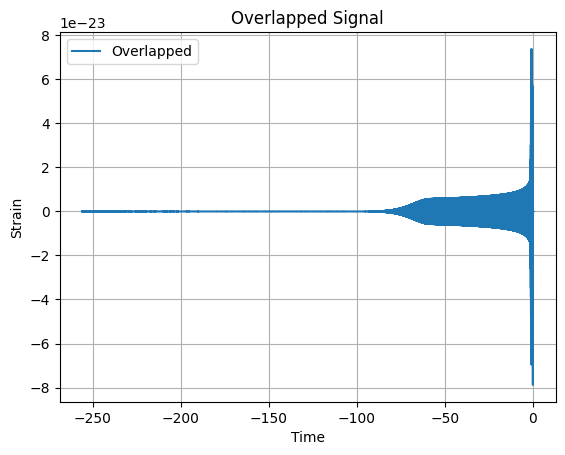

-255.8


In [4]:
def overlap(ht_1,ht_2,buffer):
    
    #Equal lengths of signals
    ht_2.resize(len(ht_1))
    
    #Shifting the merger time
    ht_2=ht_2.cyclic_time_shift(ht_2.end_time - buffer)
    
    #Equating the start time of both signals
    ht_2.start_time = ht_1.start_time
    
    #Combining the signals
    ht_total = ht_1 + ht_2

    #Ploting the signals
    pp.plot(ht_total.sample_times, ht_total, label='Overlapped')
    pp.legend()
    pp.title('Overlapped Signal')
    pp.ylabel('Strain')
    pp.xlabel('Time')
    pp.grid()
    pp.show()
    
    return ht_total,ht_2

ht_total,h1_bbh = overlap(h1_bns,h1_bbh,1)
print(ht_total.start_time)

signal_1_peak = ht_total.start_time * (-1)

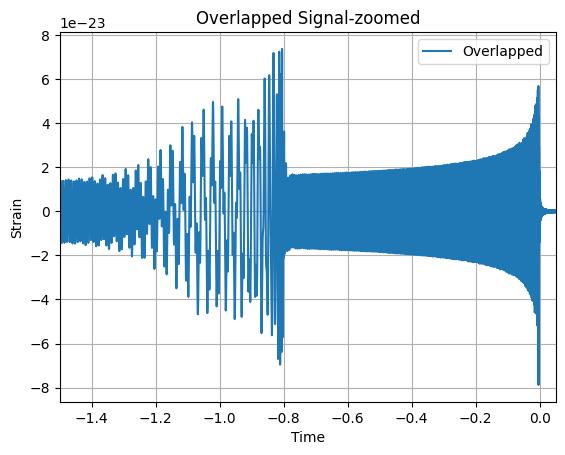

In [5]:
pp.plot(ht_total.sample_times, ht_total, label='Overlapped')
pp.xlim(-1.5,0.05)
#pp.ylim(-0.5*(10**-21),0.5*(10**-21))
pp.legend()
pp.ylabel('Strain')
pp.xlabel('Time')
pp.title('Overlapped Signal-zoomed')
pp.grid()
pp.show()



# Injecting strain into noise

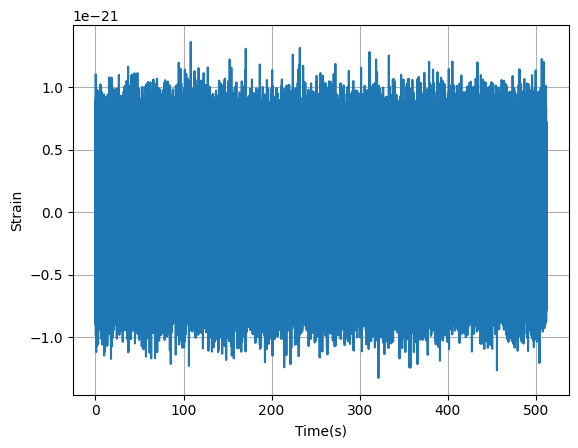

255.8
254.8


In [6]:
def inject(ht_total,ts):
    
    #Resizing the signal
    ht_total.resize(len(ts)) 
    
    #Equating the start time
    ht_total.start_time = ts.start_time
    
    #Injecting signal into noise
    ts = ts.add_into(ht_total) 
    
    #plotting the result
    pp.plot(ts.sample_times, ts)
    pp.xlabel('Time(s)')
    pp.ylabel('Strain')
    pp.grid()
    pp.show()
    
    return ts 

ts1 = inject(ht_total,noise)

signal_2_peak = signal_1_peak-1



print(signal_1_peak)
print(signal_2_peak)


# Calculating Power spectral density

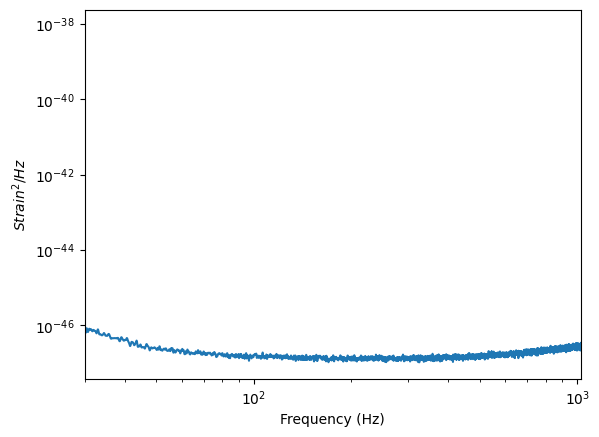

In [7]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

    pp.loglog(psd.sample_frequencies, psd)
    pp.ylabel('$Strain^2 / Hz$')
    pp.xlabel('Frequency (Hz)')
    pp.xlim(30, 1024)
    
    return psd

psd1 = psd_data(ts1)
    

# Creating Template bank

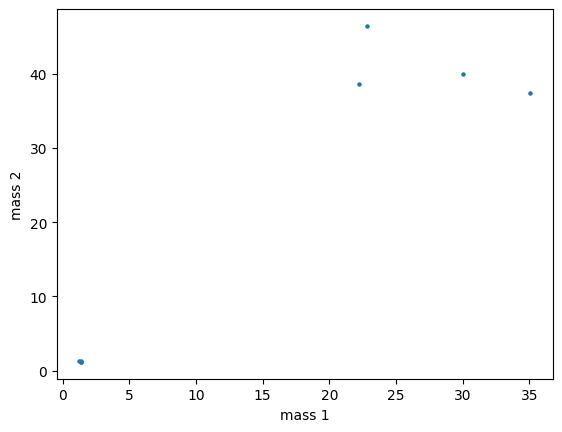

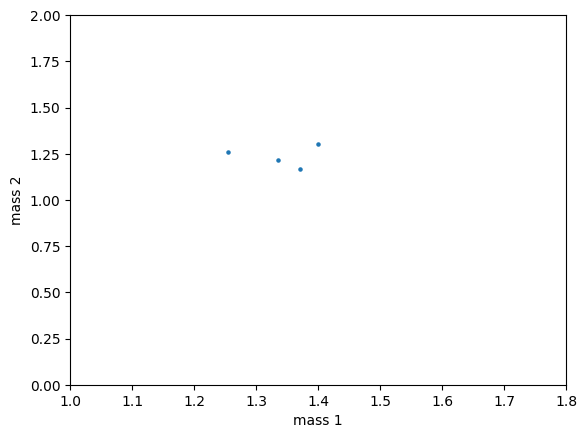

In [8]:
import numpy as np
import matplotlib.pyplot as pp

np.random.seed(0)

# BNS signal parameters
bns_m1 = 1.4
bns_m2 = 1.3
bns_radius = 0.25

# BBH signal parameters
bbh_m1 = 30
bbh_m2 = 40
bbh_radius = 10

# Number of templates per signal
num_templates = 4

# Generate templates for BNS
bns_templates = np.zeros((num_templates, 2))
for i in range(num_templates):
    r1 = np.random.uniform(0,bns_radius)
    r2 = np.random.uniform(0,(np.pi*2))           
    m1 = r1*(np.cos(r2)) + bns_m1
    m2 = r1*(np.sin(r2)) + bns_m2
    
    bns_templates[i, :] = [m1, m2]
    
bns_templates[i,:] = [bns_m1,bns_m2]

# Generate templates for BBH
bbh_templates = np.zeros((num_templates, 2))
for i in range(num_templates):
    r1 = np.random.uniform(0,bbh_radius)
    r2 = np.random.uniform(0,(np.pi*2))           
    m1 = r1*(np.cos(r2)) + bbh_m1
    m2 = r1*(np.sin(r2)) + bbh_m2
    
    bbh_templates[i, :] = [m1, m2]
    
bbh_templates[i,:] = [bbh_m1,bbh_m2]

# Combine the templates into a single bank
template_bank = np.concatenate([bns_templates, bbh_templates])

# Plot the template bank
pp.scatter(template_bank[:, 0], template_bank[:, 1], s=5)
pp.xlabel("mass 1")
pp.ylabel("mass 2")
pp.show()


pp.scatter(template_bank[:, 0], template_bank[:, 1], s=5)
pp.xlabel("mass 1")
pp.ylabel("mass 2")
pp.xlim(1.0,1.8)
pp.ylim(0,2)
pp.show()



In [9]:
 for i in range(4):
    print(bns_templates[i,:])

[1.37022935 1.16606541]
[1.25526172 1.25806482]
[1.33555592 1.2159484 ]
[1.4 1.3]


In [10]:
 for i in range(4):
         print(bbh_templates[i,:])

[22.83420858 46.44329302]
[22.21287256 38.57048965]
[35.07094615 37.44012353]
[30. 40.]


# Generating Template 

In [11]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0



    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    ht_template = fp * hp + fc * hc
    
    #Resizing the template to match data
    ht_template.resize(len(conditioned))
    
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)
    
   
    return template


# Generating SNR

In [12]:
def gen_SNR(template,conditioned,psd):
    from pycbc.filter import matched_filter
    import numpy

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)



    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.

   
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
   
    
    return snr,time

# Calculating SNR time series for template bank

In [13]:
snr_bank_bns = []
snr_times_bns = []

snr_bank_bbh = []
snr_times_bbh = []

for i in range(4):
    T1 = gen_template('TaylorF2',bns_templates[i][0],bns_templates[i][1],0.5,0.5,ts1)
    S1,time_bns = gen_SNR(T1,ts1,psd1)
    snr_bank_bns.append(S1)
    snr_times_bns.append(time_bns)
    
    T2 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.8,0.8,ts1)
    S2,time_bbh = gen_SNR(T2,ts1,psd1)
    snr_bank_bbh.append(S2)
    snr_times_bbh.append(time_bbh)
    

In [14]:

# snr_bank_bbh = []
# snr_times_bbh = []

# for i in range(4):
#     T2 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.8,0.8,ts1)
#     S2,time = gen_SNR(T2,ts1,psd1)
#     snr_bank_bbh.append(S2)
#     snr_times_bbh.append(time)

# Chi-square Test

In [15]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):
    
    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)
    
    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2
    
    
    
    return chisq


# Calculating new SNR with template bank

In [16]:
bns_info = []
bbh_info = []

for i in range(4):
    T1 = gen_template('TaylorF2',bns_templates[i,:][0],bns_templates[i,:][1],0.5,0.5,ts1)
    chisq_1 = gen_chisquare(T1,ts1,bns_templates[i,:][0],bns_templates[i,:][1],0.5,0.5,psd1)
    new_snr_bns = newsnr(abs(snr_bank_bns[i]),chisq_1)
    peak_bns = abs(new_snr_bns).argmax()
    snrp_bns = new_snr_bns[peak_bns]
    bns_info.append([bns_templates[i,:][0],bns_templates[i,:][1],snrp_bns,snr_times_bns[i]])
    
    
    T2 = gen_template('IMRPhenomPv2',bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,ts1)
    chisq_2 = gen_chisquare(T2,ts1,bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,psd1)
    new_snr_bbh = newsnr(abs(snr_bank_bbh[i]),chisq_2)
    peak_bbh = abs(new_snr_bbh).argmax()
    snrp_bbh = new_snr_bbh[peak_bbh]
    bbh_info.append([bbh_templates[i,:][0],bbh_templates[i,:][1],snrp_bbh,snr_times_bbh[i]])

In [17]:
# bbh_info = []

# for i in range(4):
#     T2 = gen_template('IMRPhenomPv2',bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,ts1)
#     chisq_2 = gen_chisquare(T2,ts1,bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,psd1)
#     new_snr = newsnr(abs(snr_bank_bbh[i]),chisq_2)
#     peak = abs(new_snr).argmax()
#     snrp = new_snr[peak]
#     bbh_info.append([bbh_templates[i,:][0],bbh_templates[i,:][1],snrp,snr_times_bbh[i]])

# Combining the list and finding the first signal

In [18]:
total_info = [*bbh_info,*bns_info]

info = {}
for i in total_info:
    info.update({i[2] : [i[0],i[1],i[3]]})

    
print(max(info.keys()))
print(info.get(max(info.keys())))


snrp_1 = max(info.keys())
time_1 = info.get(max(info.keys()))[2]
m1_1 = info.get(max(info.keys()))[0]
m2_1 = info.get(max(info.keys()))[1]
print(time_1)

11.767174994658683
[1.4, 1.3, 255.800048828125]
255.800048828125


# Aligning and subtracting the first signal

In [19]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time_1 - ts1.start_time 
template = gen_template('TaylorF2',m1_1,m2_1,0.5,0.5,ts1)
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd1, low_frequency_cutoff=30.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp_1).to_timeseries()
aligned.start_time = ts1.start_time


# Visualising the data and template

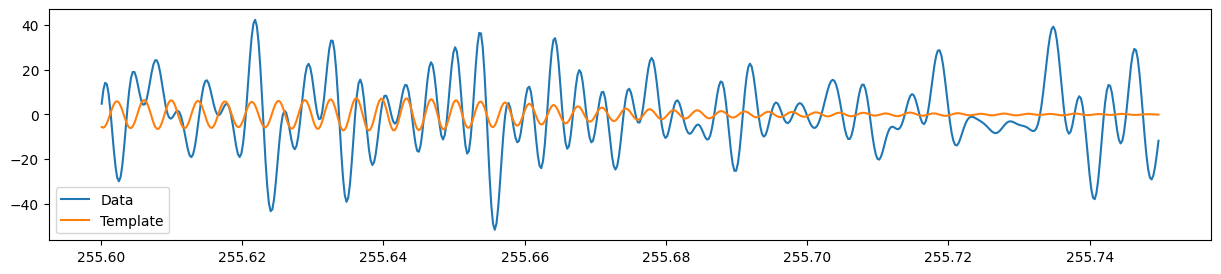

In [20]:
# We do it this way so that we can whiten both the template and the data
white_data = (ts1.to_frequencyseries() / psd1**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd1**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(255.60, 255.75)
white_template = white_template.time_slice(255.60, 255.75)

pp.figure(figsize=[15, 3])
pp.plot(white_data.sample_times, white_data, label="Data")
pp.plot(white_template.sample_times, white_template, label="Template")
pp.legend()
pp.show()

# Subtracting the first signal from data

Text(0, 0.5, 'Strain')

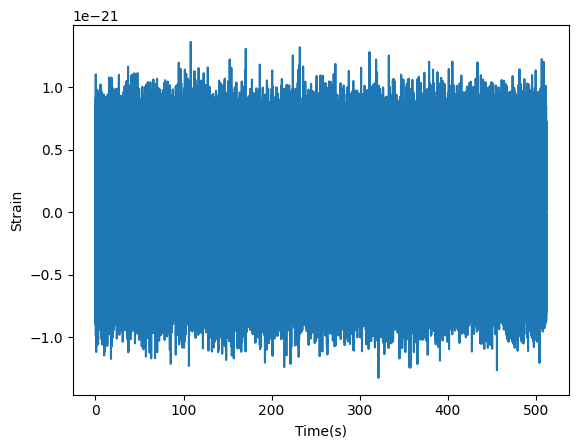

In [21]:
subtracted = ts1 - aligned

pp.plot(subtracted.sample_times,subtracted)
pp.xlabel('Time(s)')
pp.ylabel('Strain')
# |pp.xlim(254.95,255.05)
# pp.show()

# print(subtracted_time)

##### Calculating PSD of data after subtracting first signal

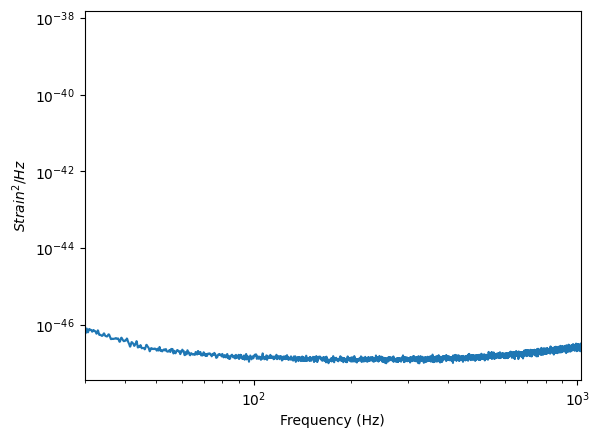

In [22]:
psd2 = psd_data(subtracted)    

# Calculating SNR time series for template bank after subtracting the first signal

In [23]:
snr_bank_bns_sub = []
snr_times_bns_sub = []


snr_bank_bbh_sub = []
snr_times_bbh_sub = []


for i in range(4):
    T1_sub = gen_template('TaylorF2',bns_templates[i,:][0],bns_templates[i,:][1],0.5,0.5,ts1)
    S1_sub,time_bns_sub = gen_SNR(T1_sub,subtracted,psd2)
    snr_bank_bns_sub.append(S1_sub)
    snr_times_bns_sub.append(time_bns_sub)
    
    
    
    T2_sub = gen_template('IMRPhenomPv2',bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,ts1)
    S2_sub,time_bbh_sub = gen_SNR(T2_sub,subtracted,psd2)
    snr_bank_bbh_sub.append(S2_sub)
    snr_times_bbh_sub.append(time_bbh_sub)

# Calculating new SNR with template bank after subtracting first signal

In [24]:
bns_info_sub = []
bbh_info_sub = []


for i in range(4):
    T1_sub = gen_template('TaylorF2',bns_templates[i,:][0],bns_templates[i,:][1],0.5,0.5,subtracted)
    chisq_1_sub = gen_chisquare(T1_sub,subtracted,bns_templates[i,:][0],bns_templates[i,:][1],0.5,0.5,psd2)
    new_snr_bns_sub = newsnr(abs(snr_bank_bns_sub[i]),chisq_1_sub)
    peak_bns_sub = abs(new_snr_bns_sub).argmax()
    snrp_bns_sub = new_snr_bns_sub[peak_bns_sub]
    bns_info_sub.append([bns_templates[i,:][0],bns_templates[i,:][1],snrp_bns_sub,snr_times_bns_sub[i]])
    
    
    
    T2_sub = gen_template('IMRPhenomPv2',bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,subtracted)
    chisq_2_sub = gen_chisquare(T2_sub,subtracted,bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,psd2)
    new_snr_bbh_sub = newsnr(abs(snr_bank_bbh_sub[i]),chisq_2_sub)
    peak_bbh_sub = abs(new_snr_bbh_sub).argmax()
    snrp_bbh_sub = new_snr_bbh_sub[peak_bbh_sub]
    bbh_info_sub.append([bbh_templates[i,:][0],bbh_templates[i,:][1],snrp_bbh_sub,snr_times_bbh_sub[i]])

# Finding the second signal

In [25]:
total_info_sub = [*bbh_info_sub,*bns_info_sub]
info_sub = {}
for i in total_info_sub:
    info_sub.update({i[2] : [i[0],i[1],i[3]]})

In [26]:
print(max(info_sub.keys()))
print(info_sub.get(max(info_sub.keys())))

5.715306478795105
[1.3702293483143464, 1.1660654089526412, 498.843505859375]
